# Kaggle Competition: TensorFlow - Help Protect the Great Barrier Reef

## Goal:
Accurately identify crown-of-thorns starfish (COTS) by building an object detection model trained on underwater videos of coral reefs.


## Context:
The Great Barrier Reef is the world’s largest coral reef, home to over 1000 species of fishes, 400 species of corals, 130 species of sharks, rays, and a massive variety of other sea life. Unfortunately, the reef is under threat, in part because of the overpopulation of COTS. Hence, a consortium of scientists, tourism operators and reef managers established an intervention program to control COTS outbreaks, whereby a Kaggle competition has been setup to help towards this goal.

Traditionally, the "Manta Tow" performed by a snorkel diver being towed by a boat is employed as a reef survey method. Every 200m, the diver would pause to record variables and visually assess the reef. The main drawbacks of this method are operational scalability, data resolution, reliability, and traceability. Through the Great Barrier Reef Foundation, a new survey and intervention method is being developed which will utilise underwater cameras to collect thousands of reef images, and AI algorithms to improve the efficiency and scale at which COTS are being detected to better mitigate their outbreaks.

Through this Kaggle crowd-sourcing competition, it is expected that an innovative machine/deep learning algorithm would emerge that can analyse large image datasets accurately, efficiently, and in near real-time.

## Team members
Marcelina, Nancy, Ulrich, Akhil

## Assessment metric

This Kaggle competition is evaluated on the [F2 Score at different intersection over union (IoU) thresholds](https://www.kaggle.com/c/tensorflow-great-barrier-reef/overview/evaluation). An F2 metric has been selected for this particular case since it weights recall more heavily than precision, given that it would be more beneficial to ensure very few starfish are missed by tolerating some false positives.

Precision looks at how accurately the true positives have been identified from the total retrieved elements, whereby keeping false positives to a minimum is preferred. On the other hand, recall looks at how accurately true positives have been identified from the total of relevant elements consisting of true positives and false negatives, that is the total number of elements that should have been identified correctly as positive. 


The F2 score is computed using the equation below, where beta is replaced by 2.

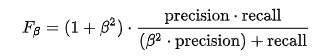


Image courtesy of Wikipedia: [F-score](https://en.wikipedia.org/wiki/F-score)


As a side note, the IoU is a method for assessing the overlap between two bounding boxes, usually the ground-truth versus the prediction bounding boxes. The mathematical expression of IoU computation is given in the image below, where an IoU = 1 exists when the prediction is completely correct. Thus, the lower the IoU score, the worse the prediction.

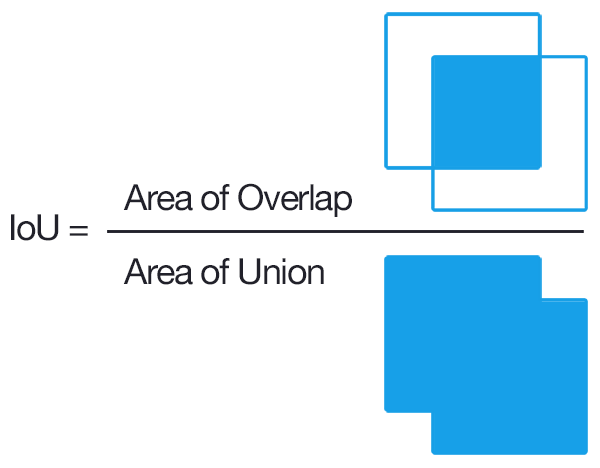

Image courtesy of Wikipedia: [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)


## Methodology

Our initial approach was for every team member to choose his preferred framework, and to try to build up a baseline model. After comparing the initial results from each of the baseline models, we proceeded to fine-tune and improve the model with the inital best score. Only one of the team members had previous experience with deep learning techniques, he went ahead training the model with his preferred framework, that is PyTorch. The other three members did not have any previous experience with deep learning nor computer vision, hence initially had to gained a foundational knowledge of those. They explored Keras and Tensorflow but ultimately these were dropped since we could not get these notebooks to properly submit to Kaggle. Thus, we decided to go with PyTorch. 

Given how complicated it is to trained an object detection network from scratch and limited time and computing resources available for the competition, we adopted the strategy of fine-tuning an already trained model. We selected FasterRCNN which is an end convolution neural Region-based Convolutional Neural Network. Before diving into the details of the model and our implementation, let's first explore the data.

In terms exploratory data analysis, every member was assigned the task to dig dipped in the data as much as he/she could in order to try pick up any patterns.


## Exploratory Data Analysis (EDA)

Understanding the dataset, provided by [3].

The dataset consists of folder with the different images split in different folders corresponding to which video they belong. 

Along side these images, we have train.csv file that contains the different annotations and meta data for the all the images.

No duplicated images nor corrupted data were found.  


In [4]:
# import some necessary packages
import ast
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from os import listdir, path
from PIL import Image, ImageDraw

In [5]:
# Accessing the train dataset.
data_dir = '../input/tensorflow-great-barrier-reef/'
df_train = pd.read_csv(data_dir + 'train.csv')
df_train

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


In [7]:
# Checking if any of the columns have missing values
print(df_train.isna().sum())

video_id          0
sequence          0
video_frame       0
sequence_frame    0
image_id          0
annotations       0
dtype: int64


In [8]:
# Checking the first 10 elements of the dataframe
df_train.head(10).style.background_gradient(cmap='Reds')

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
5,0,40258,5,5,0-5,[]
6,0,40258,6,6,0-6,[]
7,0,40258,7,7,0-7,[]
8,0,40258,8,8,0-8,[]
9,0,40258,9,9,0-9,[]


In [9]:
# Checking the last 10 elements of the dataframe
df_train.tail(10).style.background_gradient(cmap='Reds')

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
23491,2,29859,10750,2978,2-10750,[]
23492,2,29859,10751,2979,2-10751,[]
23493,2,29859,10752,2980,2-10752,[]
23494,2,29859,10753,2981,2-10753,[]
23495,2,29859,10754,2982,2-10754,[]
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]
23500,2,29859,10759,2987,2-10759,[]


In [10]:
# Accessing the test dataset 
df_test = pd.read_csv(data_dir + 'test.csv')
df_test

,video_id,sequence,video_frame,sequence_frame,image_id
0,3,17063,0,0,3-0
1,3,17063,1,1,3-1
2,3,17063,2,2,3-2


In [11]:
# Understanding dataset through its statiscal distribution
df_train.describe()

,video_id,sequence,video_frame,sequence_frame
count,23501.000000,23501.000000,23501.000000,23501.000000
mean,1.078848,33181.644994,5727.471257,974.231224
std,0.802202,18804.050915,3528.411913,795.594611
min,0.000000,996.000000,0.000000,0.000000
25%,0.000000,15827.000000,2349.000000,336.000000
50%,1.000000,29859.000000,5553.000000,740.000000
75%,2.000000,45518.000000,9048.000000,1447.000000
max,2.000000,60754.000000,12347.000000,2987.000000


In [12]:
# Checking for duplicates
print('Number of duplicates present: ', df_train.duplicated().sum())
#df_train.drop_duplicates()

Number of duplicates present:  0


In [ ]:
# Checking for corrupted data
# https://stackoverflow.com/questions/46854496/python-script-to-detect-broken-images

# not sure if this is good practice to just loop images this way. We can handle this is a better way while training

def verify_images(video_id):
    img_path = data_dir + 'train_images/video_{}/'.format(video_id)
    
    print('Verifying that video {} frames are valid...'.format(video_id))
    for filename in listdir(img_path):
        if filename.upper().endswith('.JPG'):  
            try:
                img = Image.open(os.path.join(img_path, filename))
                img.verify() # Verify it is in fact an image
            except (IOError, SyntaxError) as e:
                print('Bad file: ', filename) 
                #os.remove(img)
    print('Verified! Video {} has no corrupted images'.format(video_id))

for video_id in range(3):
    verify_images(video_id)

Verifying that video 0 frames are valid...
Verified! Video 0 has no corrupted images
Verifying that video 1 frames are valid...


Checking number of images with bounding boxes (i.e. with at least one start fish)

In [ ]:
df_train_boxes = df_train[df_train.annotations != '[]']
len(df_train_boxes)

In [ ]:
# Finding image with maximum number of bounding boxes
max_boxes = df_train['annotations'].str.count('x').max()
image_with_max_boxes = df_train['annotations'].str.count('x').idxmax()
print('Maximum number of boxes: ', max_boxes)
print('Corresponding image number: ', image_with_max_boxes)
print(df_train.iloc[image_with_max_boxes])

In [ ]:
# Defining function to show values on top of bars for barplots
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
#  Plotting total and annotated-only dataframes     
f, axs = plt.subplots(1,2,
                      figsize=(16,8),
                      sharey=True)

df1 = df_train["video_id"].value_counts().reset_index()
df2 = df_train_boxes["video_id"].value_counts().reset_index()

sns.barplot(data=df1, x="index", y="video_id", ax=axs[0],
            palette='Set2')
show_values_on_bars(axs[0], h_v="v", space=0.1)
axs[0].set_xlabel("")
axs[0].set_ylabel("")

sns.barplot(data=df2, x="index", y="video_id", ax=axs[1],
            palette='Set2')
show_values_on_bars(axs[1], h_v="v", space=0.1)
axs[1].set_xlabel("")
axs[1].set_ylabel("")

f.text(0.25, 1, 'Total number of images per video directory', ha='center')
f.text(0.75, 1, 'Number of annotated images per video directory', ha='center')
f.text(0.25, -0.05, 'Video ID', ha='center')
f.text(0.75, -0.05, 'Video ID', ha='center')
f.text(0, 0.5, 'Number of images', va='center', rotation='vertical')
f.text(0, 0, '')

In [ ]:
# Statistics of the above
def percentage_of(part, whole):
    percentage_res = (part/whole)*100
    return np.round(percentage_res, 1)

total_img = len(df_train)
no_img_0 = len(df_train[df_train["video_id"] == 0])
no_img_1 = len(df_train[df_train["video_id"] == 1])
no_img_2 = len(df_train[df_train["video_id"] == 2])
print('Video ID 0 makes up {}% of the total amount of videos.'.format(percentage_of(no_img_0, total_img)))
print('Video ID 1 makes up {}% of the total amount of videos.'.format(percentage_of(no_img_1, total_img)))
print('Video ID 2 makes up {}% of the total amount of videos.'.format(percentage_of(no_img_2, total_img)))

print()
total_img_anno = len(df_train_boxes)
no_img_0_anno = len(df_train_boxes[df_train_boxes["video_id"] == 0])
no_img_1_anno = len(df_train_boxes[df_train_boxes["video_id"] == 1])
no_img_2_anno = len(df_train_boxes[df_train_boxes["video_id"] == 2])
print('Video ID 0 has {}% of its videos annotated.'.format(percentage_of(no_img_0_anno, no_img_0)))
print('Video ID 1 has {}% of its videos annotated.'.format(percentage_of(no_img_1_anno, no_img_1)))
print('Video ID 2 has {}% of its videos annotated.'.format(percentage_of(no_img_2_anno, no_img_2)))

In [ ]:
# Calculate the number of total annotations within the frame
df_train["no_annotations"] = df_train["annotations"].apply(lambda x: len(eval(x)))
#df_train["no_annotations"].head(25)

In [ ]:
# % annotations
n = len(df_train)
no_annot = round(df_train[df_train.no_annotations==0].shape[0]/n*100)
with_annot = round(df_train[df_train.no_annotations!=0].shape[0]/n*100)

print(f"There are about {no_annot}% frames with no annotations and",
      "\n",
      f"about {with_annot}% frames with at least 1 annotation.")
print()

# Plot
plt.figure(figsize=(23, 10))
sns.histplot(df_train["no_annotations"], bins=(np.arange(18)-0.5), kde=True, element="step", 
             color='b')

plt.xlabel("Number of annotations")
plt.ylabel("Frequency")
plt.title("Distribution of annotations per image frame")
plt.xticks(range(0,20,1))

sns.despine(top=True, right=True, left=False, bottom=True)


print('It can be seen from the histogram that most annotated images have 1 or 2 bounding boxes.')

In [ ]:
# Plotting image with highest amount of bounding boxes

def fetch_image_list(df_tmp, video_id, num_images, start_frame_idx):
    def fetch_image(frame_id):
        path_base = data_dir + 'train_images/video_{}/{}.jpg'
        raw_img = Image.open(path_base.format(video_id, frame_id))

        row_frame = df_tmp[(df_tmp.video_id == video_id) & (df_tmp.video_frame == frame_id)].iloc[0]
        bounding_boxes = ast.literal_eval(row_frame.annotations)

        for box in bounding_boxes:
            draw = ImageDraw.Draw(raw_img)
            x0, y0, x1, y1 = (box['x'], box['y'], box['x']+box['width'], box['y']+box['height'])
            draw.rectangle( (x0, y0, x1, y1), outline=180, width=3)
        return raw_img

    return [np.array(fetch_image(start_frame_idx + index)) for index in range(num_images)]

images = fetch_image_list(df_train, video_id = 1, num_images = 1, start_frame_idx = 9114)

print('Image Number: ', 9114)
plt.figure(figsize=(33, 12))
plt.imshow(images[0], interpolation='nearest')
plt.axis('off')
plt.show()

## Training the baseline model

We will not run the cells in this training section. We will just explain what these are supposed to do.

Before we settled on using PyTorch, we trained the model using Tensorflow and Keras libraries but PyTorch performed better. We used the FasterR-CNN pre-trained model and fine-tuned it as per the requirements of this project. One of the first steps when preparing to train a model is build a dataloader than can feed in the model with data at every step of the training. Hence, our first step was to build a PyTorch Dataset loader.

PyTorch uses torch.utils.data.DataLoader and torch.utils.data.Dataset class to work with data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset. For this object detection project, we will be using a TorchVision dataset. To declare, initialize, and manipulate objects in Python, we use classes. The getitem reads the image using the image_id we have in the dataframe, and also we can get all the bounding boxes associated with that image. We then initialize a dict called target, which will be passed to model for training. This target will have metadata of the annotation like actual bounding box coordinates, its corresponding labels, image_id, area of the bounding boxes. The area parameter is used during evaluation with the COCO metric, to separate the metric scores between small, medium, and large boxes. If we set iscrowd as True, those instances will be ignored during evaluation. The len method gives the size of the Dataset.

<div class="alert alert-block alert-success">
<b>NOTE:</b> Since we trained our on model on Kaggle, unfortunately we had to re-install certain packages not available on Kaggle. The pycocotools package used by our model, its release version on PyPi is broken, so we had to install a working branch from github. The next cells are pip installs of the necessary libraries, and also adding of utility scripts to our programming environment. As we said earlier, we will not run any of these training cells in our report notebook.
</div>

In [ ]:
# Try doing all the installations here
!pip install -I numpy

!pip install -I torchvision
!pip install -I torch -U   

# First, we need to install pycocotools. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -I 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' --no-binary pycocotools
!ls /kaggle/input/baseline-predict-pytorch

!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2


!cp vision/references/detection/utils.py /kaggle/working/
!cp vision/references/detection/transforms.py /kaggle/working/
!cp vision/references/detection/coco_eval.py /kaggle/working/
!cp vision/references/detection/engine.py /kaggle/working/
!cp vision/references/detection/coco_utils.py /kaggle/working/

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys
import os

# os.environ['TORCH_HOME'] = '\\kaggle\\input\\resnet'

import glob
import sklearn
import math
import random

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import get_cosine_schedule_with_warmup

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import GroupKFold
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

In [ ]:
# These are some utilties functions for plotting the image.
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
    color='red'
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor=color,
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def draw_image(
    image, bboxes=None, pboxes=None, image_id=None, color2='blue', draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)
    if image_id is not None:
        ax.set_title(f"(Tp, Fn, Fp) = {image_id}")

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes, color='red')
    if pboxes is not None:
        draw_bboxes_fn(ax, pboxes, color=color2)

    plt.show()

In [ ]:
class DataAdaptor:
    def __init__(self,df):
        self.df = df
    def __len__(self):
        return len(self.df)
    
    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720) 
        
        return boxes
    
    def get_image_bb(self , idx):
        img_src = self.df.loc[idx,'path']
        image   = cv2.imread(img_src)
        image   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        row     = self.df.iloc[idx]
        bboxes  = self.get_boxes(row) 
        class_labels = np.ones(len(bboxes))
        return image, bboxes, class_labels, idx
    
    def show_overlay(self, image, boxes, pboxes, image_id, color2="blue"):
        draw_image(image, bboxes.tolist(), pboxes.tolist(), image_id=image_id, color2=color2)
        
    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_bb(index)
        print(f"image_id: {image_id}")
        draw_image(image, bboxes.tolist())
#         print(class_labels) 
        return image

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from torchvision import transforms

from typing import List, Dict


# This is our main pytorch dataset class.
# This is initialise from a pandas data frame
class CotsData(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.ds = df
        self.transforms = transforms
    
    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720) 
        
        return boxes
            
    def __getitem__(self, idx):
        # load images
        img_path = self.ds.loc[idx,'path']
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        
        row = self.ds.iloc[idx]
        boxes = self.get_boxes(row)
        num_objs = self.ds.loc[idx, 'number_boxes']

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # check this probably have to set this to true

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ds)

In [ ]:
# train only on images with detections let see
df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
df['path'] = [f"../input/tensorflow-great-barrier-reef/train_images/video_{a}/{b}.jpg" for a,b in zip(df["video_id"],df["video_frame"])]
df['annotations'] = df['annotations'].apply(eval)
df['number_boxes'] = df['annotations'].apply(lambda x: len(x))
df.head()

## Training, Validation Datasets and Data Loaders.

The next step is to create our training and validation datasets. The data loader loads the training data in batches into the model for training. For this also we will be using PyTorch’s DataLoader utility. From the EDA we observed that most of the images did not have annotations. Also, we realised after previous training that the sequence was important. So we decided to use the images from video 0 and video 1 for training and use Video 2 for testing. Also we tried to balance the dataset by dropping most of the images without annotations. Overall, we used all the images with annotations. For training, we added 1000 images without annotations, and 100 images without annotations for testing.

In [ ]:
# get training and validation dataframes
def get_train_val(df, train=True):
    if train:
        df2 = df[df.video_id != 2]
        dfn = df2[df.number_boxes>0]
        dfo = df2[df.number_boxes==0]
        dfno = dfo.sample(n=1000, replace=False, random_state=1)
        result = pd.concat([dfn, dfno])
    else:
        df2 = df[df.video_id==2]
        dfn = df2[df.number_boxes>0]
        dfo = df2[df.number_boxes==0]
        dfno = dfo.sample(n=100, replace=False, random_state=1)
        result = pd.concat([dfn, dfno])
    
    return result

In [ ]:
# fold_n = 1
# train_df= df[df.fold != fold_n]
# val_df  = df[df.fold == fold_n]

train_df = get_train_val(df, train=True)
val_df = get_train_val(df, train=False)

# use our dataset and defined transformations
dataset = CotsData(train_df.reset_index(drop=True), get_transform(train=True))
dataset_test = CotsData(val_df.reset_index(drop=True), get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
#         transforms.append(T.RandomPhotometricDistort())
#         transforms.append(T.RandomZoomOut())
    return T.Compose(transforms)

## Faster R-CNN
The Faster R-CNN profoundly replaces the Selective Search technique with much efficient Region Proposal Network that generates the detected areas in an image. It is highly used for carrying out real-time performance-based tasks in object detection tasks. We initialize our model using torchvision’s FasterRCNN and investigate different backbones namely:
- Resnet50
- Mobilenet v3
- Mobilenet v3 320
   
They were trained with all other variables being equalled, and the two mobilenet trainers produced the least good Kaggle scores, with Mobilenet v3 320 being the worst. Thus, the choice was made to continue with Resnet50. Furtheremore, some brief hyperparameter fine-tuning was carried out. It was found that an epoch number of 20 produced the best result when compared to epoch numbers of 1, 10, 30, and 40. Longer epochs of 30 and 40 produced less good results mostly likely due to overfitting. Another variable which was investigated was the backbone number, where a default number of 3 produced better results than that of 4. Again, this is most likely due to overfitting occuring at a higher backbone number producing a worse result.  

The optimizer we are using here is SGD (Stochastic Gradient Descent). The learning rate scheduler helps to adjust the learning rate during the course of the training to achieve more accuracy and speed up convergence. We use StepLR scheduler which decays the learning rate of each parameter group by gamma every step_size epochs. The gamma and step_size hyperparameters will decide the learning rate decay. 


## Augmentations
We tried different Augmentations namely, Horizontal flip, RandomPhotometricDistort, RandomZoomOut. Horizontal flip gave the best results and continued with it. But it should be noted we could really explore more of these.


## Hyperparameter fine-tuning
Other than the number of epochs and number of layers in the backbone pretrained Resnet50 model, we did not have enough time to perform an extensive hyperparameter fine-tuning. Also were trying to explore different models and parameters of our model that could improve the model, before fine-tuning the hyperparameters of our best model.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # trainable_backbone_layers=4
    #model.load_state_dict(torch.load('/kaggle/input/resnet/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'))

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    #hidden_layer = 256

    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model.state_dict(), 'checkpoint-video2.pth')


import os
os.chdir(r'../working')
from IPython.display import FileLink
FileLink(r'checkpoint-video2.pth')

### Analysis of the model

After training the model is saved as a PyTorch dictionary class of weights. Hence, we can re-initialise the model using the saved dictionry for prediction and analysis.

In [ ]:
# Again we have to add the same utility scripts we used for training here
!cp /kaggle/input/k/ulricharmel/baseline-predict-pytorch/utils.py /kaggle/working/
!cp /kaggle/input/k/ulricharmel/baseline-predict-pytorch/transforms.py /kaggle/working/
!cp /kaggle/input/k/ulricharmel/baseline-predict-pytorch/coco_eval.py /kaggle/working/
!cp /kaggle/input/k/ulricharmel/baseline-predict-pytorch/engine.py /kaggle/working/
!cp /kaggle/input/k/ulricharmel/baseline-predict-pytorch/coco_utils.py /kaggle/working/

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False) #pretrained=True
    model.load_state_dict(torch.load('/kaggle/input/resnet/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'))

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# from engine import train_one_epoch, evaluate
# import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# we redefine the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# This loads the model
model_path = '/kaggle/input/checkvideo2/checkpoint-video2.pth'
state_dict = torch.load(model_path)
# print(state_dict.keys())
model.load_state_dict(state_dict)
model.eval()

print("Nothing important, just to prevent printing the whole model")

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3, score_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    # function to implement non maximum suppression
    # might also need to eliminate predictions with very low scores
    # trim low scores first
    
    keep = orig_prediction['scores'] >= score_thresh
    
    scores_prediction = {}
    scores_prediction['boxes'] = orig_prediction['boxes'][keep]
    scores_prediction['scores'] = orig_prediction['scores'][keep]
    scores_prediction['labels'] = orig_prediction['labels'][keep]
    
    keep = torchvision.ops.nms(scores_prediction['boxes'], scores_prediction['scores'], iou_thresh)
    
    final_prediction = {}
    final_prediction['boxes'] = scores_prediction['boxes'][keep]
    final_prediction['scores'] = scores_prediction['scores'][keep]
    final_prediction['labels'] = scores_prediction['labels'][keep]
    
    return final_prediction

def compute_iou(bbox1, bbox2):
    """
    Compute the IoU between two bounding boxes.

    Parameters
    ----------
    - bbox1 (List[int]): Bounding box 1.
    - bbox2 (List[int]): Bounding box 2.

    Returns
    -iou (float): Intersection over union
    """

    # Compute the area for box1 and box2
    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    # Compute the area of the intersection
    xi1 = max(bbox1[0], bbox2[0])
    xi2 = min(bbox1[2], bbox2[2])
    yi1 = max(bbox1[1], bbox2[1])
    yi2 = min(bbox1[3], bbox2[3])
    intersection = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    # Compute the area of the union
    union = area1 + area2 - intersection

    return intersection / union

def cross_match(targets, predictions, iou_thresh=0.3, score_thresh=0.35, match_iou=0.5):
    """Cross mathc few targets
   
    Parameters
    ----------
    target : dictionary
        Ground truth (correct) target boxes.
    predictions : dictionary
        Predicted boxes
    iou_thresh : float
        Intersection over union threshold for cross matching
    score_thresh:
        Use boxes with score greater than this threshold
    match_iou:
        Consider a match is iou is greater than this value
    Returns
    -------
    match (true positive), missed (false negative), wrong (false positive)
    """
    # Drop prections with lower cores
    predictions = apply_nms(predictions, iou_thresh=iou_thresh, score_thresh=score_thresh)
    
    total_true = len(targets["boxes"])
    total_pred = len(predictions['boxes']) 
    
    match = 0
    missed = 0
    wrong = 0

    
    if total_true == 0:
        wrong = len(predictions['boxes'])
        return predictions, [match, missed, wrong]
    elif total_pred == 0:
        missed = total_true
        return predictions, [match, missed, wrong]
    else:
        for i in range(len(predictions['boxes'])):
            box = predictions['boxes'][i].cpu().detach().numpy()
            
            try:
                for j in range(len(targets['boxes'])):
                    box1 = targets['boxes'][j].cpu().detach().numpy()
                    iou = compute_iou(box, box1)
                    if iou >= match_iou:
                        match += 1
            except:
                print(targets['boxes'])
            
    missed = total_true - match
    wrong = total_pred - match
    
    return predictions, [match, missed, wrong]
                    
def preprocess_img(img):
    img = img/255.
    x,y, c = img.shape
    img = img.transpose(2, 0, 1)
    return torch.from_numpy(img)

### Looking at some predictions

In [ ]:
# train only on images with detections let see
# add the imaging paths to the dataframe
df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
df['path'] = [f"../input/tensorflow-great-barrier-reef/train_images/video_{a}/{b}.jpg" for a,b in zip(df["video_id"],df["video_frame"])]
df['annotations'] = df['annotations'].apply(eval)
df['number_boxes'] = df['annotations'].apply(lambda x: len(x))
df.head()

### Let resplit and test this on the on validation dataset

In [ ]:
val_df = get_train_val(df, train=False).reset_index(drop=True)
val_ds = DataAdaptor(val_df)
dataset_test = CotsData(val_df, get_transform(train=False))
total_images = (len(val_df))

In [ ]:
results = []
i = 0 
for img, target in dataset_test:
    prediction = model([img.to(device)])[0]
    pred, output = cross_match(target, prediction, iou_thresh=0.3, score_thresh=0.3, match_iou=0.5)
    results.append(output)
    
    img = img.cpu().detach().numpy()
    img = img.squeeze().transpose(1, 2, 0)
    
    bboxes = target['boxes'].cpu().detach().numpy()
    pboxes = pred['boxes'].cpu().detach().numpy()
    
    if i%60 ==0:
        val_ds.show_overlay(img, bboxes, pboxes, output)
    
    i+=1
    if i==total_images:
        break

results = np.asarray(results)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 2
plt.rcParams["figure.figsize"] = (20,16)

n_images, _ = results.shape
xval = np.array(range(1, n_images+1))

@np.vectorize
def fb_score(beta, tp, fn, fp):
    """Compute the f-beta score for each image
    
    Parameters:
    -b (float) - beta parameter to use
    -tp (int) - numpber of true positives
    -fn (int) - number of false negatives
    -fp (int) - number of false positive
    
    Returns:
    -fbeta (float) - fbeta score
    """
    
    if (tp == 0) and (fp==0) and (fn==0):
        return np.nan
    else:
        fb = ((1.+beta**2)*(tp))/((1.+beta**2)*(tp) + (beta**2.)*fn + fp)
    
    return fb

f2_scores = fb_score(2., results[:,0], results[:,1], results[:,2])

plt.plot(xval, results[:,0], label="True positve", color='b', linewidth=2, alpha=0.5)
plt.plot(xval, results[:,0], marker='x', markersize=3, color='b', alpha=0.5, linestyle='None')

plt.plot(xval, results[:,1], label="False negative", color='r', linewidth=2, alpha=0.5)
plt.plot(xval, results[:,1], marker='x', markersize=3, color='r', alpha=0.5, linestyle='None')

plt.plot(xval, results[:,2], label="False positive", color='g', linewidth=2, alpha=0.5)
plt.plot(xval, results[:,2], marker='x', markersize=3, color='g', alpha=0.5, linestyle='None')

plt.legend(loc='best',fontsize = 'large',numpoints=1, ncol=1)
plt.ylabel("Stats", size=20)
plt.xlabel("Test image index", size=20)
# plt.title(title, size=15)

plt.tight_layout()

plt.show()

In [ ]:
plt.plot(xval, f2_scores, label=f"mean = {np.nanmean(f2_scores)}", color='b', linewidth=2, alpha=0.5)
plt.plot(xval, f2_scores, marker='x', markersize=3, color='b', alpha=0.5, linestyle='None')

plt.legend(loc='best',fontsize = 'large',numpoints=1, ncol=1)
plt.ylabel("F2 scores", size=20)
plt.xlabel("Test image index", size=20)
# plt.title(title, size=15)

plt.tight_layout()

plt.show()

The images above shows true positives, false positves, false negatives, and F2 scores obtained for evey image in validation dataset. Here we used an IoU threshold of 0.5 to cross match the sources. We also discard predictions with scores below 0.3 as unreliable. We get an a score 0.6 using our metric. Although this score is not exactly the competition metric this gives a good indication that our model needs to improve drastically. 

## Conclusion

We were able to fine-tune and train an object dection network on the COTS dataset. Our model gives an F2-score of 0.6 using IoU threshold of 0.5 on our validation dataset. This score is quite low but it is goot initial starting score for a baseline model. Also through the process, we have all improved our knowlegde of computer vision and object detection. Also given that we using a pretrained model we had little flexbility on tweaking certain parameters.

## Recommendations for future work

Since this was a time-intensive project of about 2 weeks with most team-members performing their first computer vision + object detection + deep learning fine- tuning + Kaggle competition, there is definitely room for improvement. The following ideas were considered as potential further ameliorations, but could not be concretised given the lack of time:
- YOLO
- Hyperparameter fine-tuning
​
​

YOLO (You Only Look Once) is a fast algorithm that recognizes objects within an image. It is a single CNN and requires only one forward pass through the neural network in order to identify the objects, which makes optimisation easier. It is different from the more tradional object detection algorithms which are classification based, where as YOLO is regression based. 
​
Hyperparameter fine-tuning is another approach that can be investigated into more depths next time. Currently, for the optimiser, an SGD is being implemented. However, the effect of varying its underlyling base parameters were not explored, such as the lr (learning rate), momentum, and weight decay. Moreover, a base step learning rate scheduler was also implemented and its parameters such as the step_size and gamma were kept default. Note, the step learning rate decays the learning rate of each parameter group every step_size epochs by the gamma value. Since we were training our models on Kaggle, and had limited GPU quota of 30 hours per week, we were not able to dedicate as much time to hyperparameter fine-tuning as expected. In the second week of the DSI, an AWS elastic computing cloud (ec2) was made available but we were having difficulties running the training algorithm on it. 

Another important observation is how small the starfishes appear in the images. So another recommendation for futurework is to find the right augmentation that can address this issue.

## References 
[1] PyTorch, "Torchvision Object Detection Finetuning tutorial". URL: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html. Accessed on: 25/01/22

[2] Passos, A., "Be CAREFUL with your TRAIN/VALID splits and avoid LB GAPS". URL: https://www.kaggle.com/c/tensorflow-great-barrier-reef/discussion/293723. Accessed on: 02/02/22 

[3] Jiajun, L. et al., "The CSIRO Crown-of-Thorn Starfish Detection Dataset", 2021

[4] Kaggle notebook. URL: https://www.kaggle.com/mrinath/efficientdet-train-pytorch